# EDA bộ NSL-KDD
---

## Issue: Conflict Mapping categories

**Mapping 1** ([NSL-KDD Chi Tiết (Mapping 1)](https://inseclab.uit.edu.vn/nsl-kdd-goc-nhin-chi-tiet-ve-tap-du-lieu-huan-luyen-cho-cac-ids/)):
- **Issue**: Số liệu không khớp với thống kê chung
- **Classification**: `worm` → DoS, `httptunnel` → R2L
- **Results**:

| Dataset    | Total  | Normal      | DoS         | Probe       | U2R        | R2L          |
|------------|--------|-------------|-------------|-------------|------------|--------------|
| KDDTrain+  | 125973 | 67343 (53%) | 45927 (37%) | 11656 (9%)  | 52 (0.04%) | 995 (0.85%)  |
| KDDTest+   | 22544  | 9711 (43%)  | 7458 (33%)  | 2421 (11%)  | 67 (0.8%)  | 2885 (12.2%) |



**Mapping 2** ([NSL-KDD README (Mapping 2)](https://github.com/thinline72/nsl-kdd/blob/master/README.md)) - **✅ Sử dụng**:
- **Advantage**: Số liệu khớp chính xác với thống kê chuẩn
- **Classification**: `worm` → R2L, `httptunnel` → U2R
- **Results**:

| Dataset    | Total  | Normal      | DoS         | Probe       | U2R         | R2L          |
|------------|--------|-------------|-------------|-------------|-------------|--------------|
| KDDTrain+  | 125973 | 67343 (53%) | 45927 (37%) | 11656 (9%)  | 52 (0.04%)  | 995 (0.85%)  |
| KDDTest+   | 22544  | 9711 (43%)  | 7458 (33%)  | 2421 (11%)  | 200 (0.89%) | 2754 (12.2%) |



### Key Differences

| Attack       | Mapping 1 | Mapping 2 (Used) | Rationale                          |
|--------------|-----------|------------------|------------------------------------|
| `worm`       | DoS       | **R2L**          | Worm propagates remotely           |
| `httptunnel` | R2L       | **U2R**          | Privilege escalation context       |



---

## 1. Import thư viện và Setup

In [1]:
# Thư viện
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import Counter
import time
from functools import wraps

## Configue visualization
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

## Utils
### Decorator để track thời gian thực thi hàm
def analyze_function(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start_time = time.time()
        print(f"\nExecuting: {func.__name__}()")
        result = func(*args, **kwargs)
        print(f"Time: {time.time() - start_time:.4f}s")
        return result
    return wrapper

### Class để profile DataFrame nhằm Kiểm tra nhanh data structure
class DataProfiler:
    @staticmethod
    def profile(df, name="DataFrame"):
        print(f"\n📊 {name}")
        print(f"Shape:   {df.shape[0]:,} rows × {df.shape[1]} cols")
        print(f"Memory:  {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
        print(f"Missing: {df.isnull().sum().sum()} cells")
    
    @staticmethod
    def compare_sets(set1, set2, name1="Set1", name2="Set2"):
        """So sánh 2 sets"""
        common = set1 & set2
        only_1 = set1 - set2
        only_2 = set2 - set1
        print(f"\nSo sánh số loại tấn công ở {name1} và {name2}")
        print(f"Tổng {name1}: {len(set1)} | Tổng {name2}: {len(set2)}")
        print(f"Chung: {len(common)} loại tấn công")
        print(f"Số loại tấn công chỉ có ở {name1}: {len(only_1)}")
        print(f"Số loại tấn công chỉ có ở {name2}: {len(only_2)}")
        return {'common': common, 'only_1': only_1, 'only_2': only_2}

print("✅ Libraries imported")

✅ Libraries imported


## 2. Data Loading Functions

In [2]:
# ============================================
# FUNCTION 1: Tạo tên cột generic
# INPUT: Không
# PROCESS: Tạo tên theo cấu trúc NSL-KDD (9 + 13 + 9 + 10 features + label + difficulty)
# OUTPUT: List 43 tên cột
# MỤC ĐÍCH: Tạo column dựa trên thông tin Internet, Fallback khi không có metadata file
# ============================================
def generate_generic_column_names():
    columns = []
    columns.extend([f'intrinsic_{i}' for i in range(1, 10)])    # 9 features
    columns.extend([f'content_{i}' for i in range(1, 14)])      # 13 features  
    columns.extend([f'time_{i}' for i in range(1, 10)])         # 9 features
    columns.extend([f'host_{i}' for i in range(1, 11)])         # 10 features
    columns.extend(['attack_type', 'difficulty'])               # label + score
    return columns

# ============================================
# FUNCTION 2: Load tên cột từ metadata file
# INPUT: Đường dẫn file metadata
# PROCESS: Đọc file, mỗi dòng 1 tên cột
# OUTPUT: List tên cột (hoặc None nếu fail)
# MỤC ĐÍCH: Ưu tiên dùng tên cột chuẩn nếu có
# ============================================
def load_column_metadata(metadata_path='nslkdd_columns.txt'):
    try:
        with open(metadata_path, 'r') as f:
            columns = [line.strip() for line in f.readlines()]
        if len(columns) == 43:
            print(f"✅ Loaded columns from: {metadata_path}")
            return columns
        else:
            print(f"⚠️  Wrong column count: {len(columns)}")
            return None
    except FileNotFoundError:
        print(f"Metadata not found: {metadata_path}")
        return None

# ============================================
# FUNCTION 3: Load dữ liệu NSL-KDD
# INPUT: Đường dẫn file CSV
# PROCESS: 
#   1. Cố load metadata → nếu fail dùng generic names
#   2. Đọc CSV với tên cột vừa có
#   3. Clean: Remove dấu chấm cuối attack_type
# OUTPUT: DataFrame
# MỤC ĐÍCH: Load data linh hoạt (có/không metadata đều chạy)
# ============================================
def load_nslkdd_data(filepath, use_metadata=True):
    # Bước 1: Lấy tên cột
    if use_metadata:
        columns = load_column_metadata()
    else:
        columns = None
    
    if columns is None:
        columns = generate_generic_column_names()
        print("Using generic column names")
    
    # Bước 2: Load CSV
    df = pd.read_csv(filepath, names=columns, header=None)
    
    # Bước 3: Clean data
    df['attack_type'] = df['attack_type'].str.strip().str.rstrip('.')
    
    print(f"✅ Loaded {len(df):,} records")
    return df

print("✅ Functions defined")

✅ Functions defined


In [3]:
# Nếu đảm bảo có tên cột chuẩn từ NSL-KDD documentation, uncomment và chạy 
# nhằm tạo metadata file, hoặc skip để dùng generic names

standard_column_names = [
    # Intrinsic (1-9)
    'duration', 'protocol_type', 'service', 'flag',
    'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent',
    # Content (10-22)
    'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
    'num_shells', 'num_access_files', 'num_outbound_cmds',
    'is_host_login', 'is_guest_login',
    # Time-based (23-31)
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate',
    'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
    'diff_srv_rate', 'srv_diff_host_rate',
    # Host-based (32-41)
    'dst_host_count', 'dst_host_srv_count',
    'dst_host_same_srv_rate', 'dst_host_diff_srv_rate',
    'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
    'dst_host_serror_rate', 'dst_host_srv_serror_rate',
    'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    # Label + Difficulty
    'attack_type', 'difficulty'
]

with open('nslkdd_columns.txt', 'w') as f:
    for col in standard_column_names:
        f.write(col + '\n')
print("✅ Created metadata file")

✅ Created metadata file


## 3. Load dữ liệu

In [4]:
# INPUT: Đường dẫn đến file Train và Test
# PROCESS: Load bằng function đã define
# OUTPUT: 2 DataFrames (df_train, df_test)

data_dir = Path('H:/tdc_window/Workspace/UIT/HT_IDS/BTQT/exp_dir/exp_data')
train_file = data_dir / 'KDDTrain+.txt'
test_file = data_dir / 'KDDTest+.txt'

df_train = load_nslkdd_data(train_file)
df_test = load_nslkdd_data(test_file)

print(f"\n📊 Train: {df_train.shape[0]:,} samples")
print(f"📊 Test:  {df_test.shape[0]:,} samples")

✅ Loaded columns from: nslkdd_columns.txt
✅ Loaded 125,973 records
✅ Loaded columns from: nslkdd_columns.txt
✅ Loaded 22,544 records

📊 Train: 125,973 samples
📊 Test:  22,544 samples


In [5]:
## Xem thông tin kiểu dữ liệu
cols = df_train.columns.tolist()
print(f"Intrinsic (1-9):   {cols[0:9]}")
print(f"Content (10-22):   {cols[9:22]}")
print(f"Time (23-31):      {cols[22:31]}")
print(f"Host (32-41):      {cols[31:41]}")
print(f"Label & Score:     {cols[41:43]}")

Intrinsic (1-9):   ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent']
Content (10-22):   ['hot', 'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login']
Time (23-31):      ['count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate']
Host (32-41):      ['dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
Label & Score:     ['attack_type', 'difficulty']


## 4. Phân tích zero-day attacks

In [6]:
DataProfiler.profile(df_train, name="Train DataFrame")
DataProfiler.profile(df_test, name="Test DataFrame")

DataProfiler.compare_sets(
    set(df_train['attack_type'].unique()),
    set(df_test['attack_type'].unique()),
    name1="Train Attack Types",
    name2="Test Attack Types"
)


📊 Train DataFrame
Shape:   125,973 rows × 43 cols
Memory:  63.08 MB
Missing: 0 cells

📊 Test DataFrame
Shape:   22,544 rows × 43 cols
Memory:  11.30 MB
Missing: 0 cells

So sánh số loại tấn công ở Train Attack Types và Test Attack Types
Tổng Train Attack Types: 23 | Tổng Test Attack Types: 38
Chung: 21 loại tấn công
Số loại tấn công chỉ có ở Train Attack Types: 2
Số loại tấn công chỉ có ở Test Attack Types: 17


{'common': {'back',
  'buffer_overflow',
  'ftp_write',
  'guess_passwd',
  'imap',
  'ipsweep',
  'land',
  'loadmodule',
  'multihop',
  'neptune',
  'nmap',
  'normal',
  'perl',
  'phf',
  'pod',
  'portsweep',
  'rootkit',
  'satan',
  'smurf',
  'teardrop',
  'warezmaster'},
 'only_1': {'spy', 'warezclient'},
 'only_2': {'apache2',
  'httptunnel',
  'mailbomb',
  'mscan',
  'named',
  'processtable',
  'ps',
  'saint',
  'sendmail',
  'snmpgetattack',
  'snmpguess',
  'sqlattack',
  'udpstorm',
  'worm',
  'xlock',
  'xsnoop',
  'xterm'}}

In [7]:
# INPUT: new_attacks set, df_test
# PROCESS: Đếm số samples của mỗi zero-day attack trong Test
# OUTPUT: DataFrame với attack name, count, percentage
# MỤC ĐÍCH: Biết zero-day nào xuất hiện nhiều nhất

train_attacks = set(df_train['attack_type'].unique())
test_attacks = set(df_test['attack_type'].unique())

common_attacks = train_attacks & test_attacks      # Chung (∩)
new_attacks = test_attacks - train_attacks         # Mới ở Test (-)
missing_attacks = train_attacks - test_attacks     # Chỉ ở Train

new_attacks_data = []
for attack in sorted(new_attacks):
    count = len(df_test[df_test['attack_type'] == attack])
    percentage = (count / len(df_test)) * 100
    new_attacks_data.append({
        'Attack Type': attack,
        'Samples in Test': count,
        'Percentage': f"{percentage:.2f}%"
    })

df_new_attacks = pd.DataFrame(new_attacks_data)
df_new_attacks = df_new_attacks.sort_values('Samples in Test', ascending=False)

print("\n🎯 ZERO-DAY ATTACKS:")
print(df_new_attacks.to_string(index=False))
print(f"\nTổng: {df_new_attacks['Samples in Test'].sum():,} samples ({df_new_attacks['Samples in Test'].sum() / len(df_test) * 100:.2f}%)")


🎯 ZERO-DAY ATTACKS:
  Attack Type  Samples in Test Percentage
        mscan              996      4.42%
      apache2              737      3.27%
 processtable              685      3.04%
    snmpguess              331      1.47%
        saint              319      1.42%
     mailbomb              293      1.30%
snmpgetattack              178      0.79%
   httptunnel              133      0.59%
        named               17      0.08%
           ps               15      0.07%
     sendmail               14      0.06%
        xterm               13      0.06%
        xlock                9      0.04%
       xsnoop                4      0.02%
    sqlattack                2      0.01%
     udpstorm                2      0.01%
         worm                2      0.01%

Tổng: 3,750 samples (16.63%)


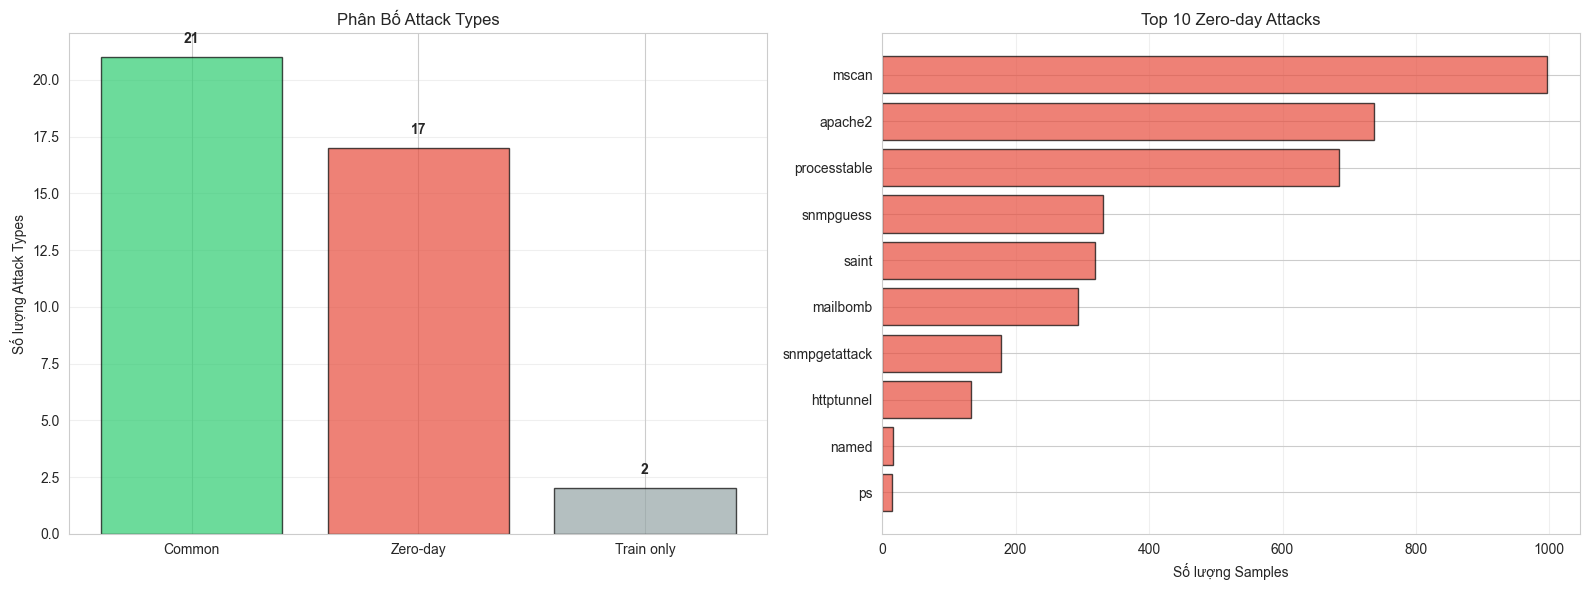

In [8]:
# INPUT: common, new, missing sets + df_new_attacks
# PROCESS: Vẽ 2 charts (bar + horizontal bar)
# OUTPUT: 2 biểu đồ
# MỤC ĐÍCH: Visual comparison dễ hiểu

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: So sánh tổng quan
categories = ['Common', 'Zero-day', 'Train only']
counts = [len(common_attacks), len(new_attacks), len(missing_attacks)]
colors = ['#2ecc71', '#e74c3c', '#95a5a6']

axes[0].bar(categories, counts, color=colors, alpha=0.7, edgecolor='black')
axes[0].set_ylabel('Số lượng Attack Types')
axes[0].set_title('Phân Bố Attack Types')
axes[0].grid(axis='y', alpha=0.3)
for i, (cat, count) in enumerate(zip(categories, counts)):
    axes[0].text(i, count + 0.5, str(count), ha='center', va='bottom', fontweight='bold')

# Chart 2: Top Zero-day attacks
if len(new_attacks) > 0:
    top_zero_day = df_new_attacks.nlargest(10, 'Samples in Test')
    axes[1].barh(top_zero_day['Attack Type'], top_zero_day['Samples in Test'], 
                 color='#e74c3c', alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Số lượng Samples')
    axes[1].set_title('Top 10 Zero-day Attacks')
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

In [9]:
# Export Zero-day attacks analysis to CSV
output_file = 'zero_day_attacks_analysis.csv'
df_new_attacks.to_csv(output_file, index=False)

print(f"✅ Zero-day attacks analysis exported to: {output_file}")

# Export full comparison
all_attacks = sorted(train_attacks | test_attacks)
comparison_data = []

for attack in all_attacks:
    train_count = len(df_train[df_train['attack_type'] == attack])
    test_count = len(df_test[df_test['attack_type'] == attack])
    status = 'Common' if attack in common_attacks else ('Zero-day' if attack in new_attacks else 'Train only')
    comparison_data.append({
        'Attack': attack,
        'Train': train_count,
        'Test': test_count,
        'Status': status
    })

df_comparison = pd.DataFrame(comparison_data)
df_comparison.to_csv('attack_types_comparison.csv', index=False)
print(f"✅ Full comparison exported to: attack_types_comparison.csv")

✅ Zero-day attacks analysis exported to: zero_day_attacks_analysis.csv
✅ Full comparison exported to: attack_types_comparison.csv


In [10]:
# # INPUT: train_attacks, test_attacks
# # PROCESS: Đếm samples mỗi attack trong Train vs Test, vẽ heatmap
# # OUTPUT: Heatmap (màu đỏ = nhiều sample, xanh = ít/không có)
# # MỤC ĐÍCH: Visual comparison Train không có (0) nhưng Test có (>0) = Zero-day

# all_attacks = sorted(train_attacks | test_attacks)
# comparison_data = []

# for attack in all_attacks:
#     train_count = len(df_train[df_train['attack_type'] == attack])
#     test_count = len(df_test[df_test['attack_type'] == attack])
#     status = 'Common' if attack in common_attacks else ('Zero-day' if attack in new_attacks else 'Train only')
#     comparison_data.append({
#         'Attack': attack,
#         'Train': train_count,
#         'Test': test_count,
#         'Status': status
#     })

# df_comparison = pd.DataFrame(comparison_data)

# # Vẽ heatmap cho Zero-day
# df_zeroday_viz = df_comparison[df_comparison['Status'] == 'Zero-day'].copy()

# if len(df_zeroday_viz) > 0:
#     fig, ax = plt.subplots(figsize=(12, max(8, len(df_zeroday_viz) * 0.4)))
#     heatmap_data = df_zeroday_viz[['Train', 'Test']].T
#     heatmap_data.columns = df_zeroday_viz['Attack'].values
    
#     sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='RdYlGn_r', 
#                 cbar_kws={'label': 'Số samples'}, linewidths=0.5, ax=ax)
#     ax.set_title('Zero-day Attacks: Train (0) vs Test (>0)', fontweight='bold')
#     ax.set_ylabel('Dataset')
    
#     plt.tight_layout()
#     plt.show()

## 5. Class imbalance

In [23]:
# ============================================
# CLASS IMBALANCE ANALYSIS
# ============================================

# Định nghĩa Attack Categories theo NSL-KDD

# MAPPING 1: Từ documentation table (bảng trong ảnh)
# attack_categories = {
#     'normal': 'Normal',
#     'DoS': ['apache2', 'back', 'land', 'neptune', 'mailbomb', 'pod', 
#             'processtable', 'smurf', 'teardrop', 'udpstorm', 'worm'],
#     'Probe': ['ipsweep', 'mscan', 'nmap', 'portsweep', 'saint', 'satan'],
#     'U2R': ['buffer_overflow', 'loadmodule', 'perl', 'ps', 'rootkit', 
#             'sqlattack', 'xterm'],
#     'R2L': ['ftp_write', 'guess_passwd', 'httptunnel', 'imap', 'multihop', 
#             'named', 'phf', 'sendmail', 'snmpgetattack', 'snmpguess', 
#             'spy', 'warezclient', 'warezmaster', 'xlock', 'xsnoop']
# }

# MAPPING 3: Attack classification theo tác giả NSL-KDD dataset (README.md)
# Reference: exp_data/README.md attack_dict
# Key differences from previous mappings:
#   - 'worm' classified as R2L (not DoS) - worm propagates remotely
#   - 'httptunnel' classified as U2R (privilege escalation context)
attack_categories = {
    'normal': 'Normal',
    'DoS': ['back', 'land', 'neptune', 'pod', 'smurf', 'teardrop',
            'mailbomb', 'apache2', 'processtable', 'udpstorm'],  # 10 attacks (NO worm)
    'Probe': ['ipsweep', 'nmap', 'portsweep', 'satan', 'mscan', 'saint'],  # 6 attacks
    'R2L': ['ftp_write', 'guess_passwd', 'imap', 'multihop', 'phf', 'spy',
            'warezclient', 'warezmaster', 'sendmail', 'named',
            'snmpgetattack', 'snmpguess', 'xlock', 'xsnoop', 'worm'],  # 15 attacks (+worm)
    'U2R': ['buffer_overflow', 'loadmodule', 'perl', 'rootkit',
            'httptunnel', 'ps', 'sqlattack', 'xterm']  # 8 attacks (+httptunnel)
}

# Map attack_type sang category
def categorize_attack(attack_type):
    if attack_type == 'normal':
        return 'Normal'
    for category, attacks in attack_categories.items():
        if category != 'normal' and attack_type in attacks:
            return category
    return 'Unknown'

df_train['category'] = df_train['attack_type'].apply(categorize_attack)
df_test['category'] = df_test['attack_type'].apply(categorize_attack)

# Tính phân bố categories
train_cat_counts = df_train['category'].value_counts()
test_cat_counts = df_test['category'].value_counts()

train_cat_pct = (train_cat_counts / len(df_train) * 100).round(2)
test_cat_pct = (test_cat_counts / len(df_test) * 100).round(2)

# Tạo comparison DataFrame
categories_list = ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
comparison_cat = []

for cat in categories_list:
    train_count = train_cat_counts.get(cat, 0)
    test_count = test_cat_counts.get(cat, 0)
    train_pct = train_cat_pct.get(cat, 0)
    test_pct = test_cat_pct.get(cat, 0)
    delta_pct = test_pct - train_pct
    multiplier = test_count / train_count if train_count > 0 else float('inf')
    
    comparison_cat.append({
        'Category': cat,
        'Train Count': train_count,
        'Train %': f"{train_pct:.2f}%",
        'Test Count': test_count,
        'Test %': f"{test_pct:.2f}%",
        'Delta %': f"{delta_pct:+.2f}%",
        'Multiplier': f"{multiplier:.1f}x" if multiplier != float('inf') else "∞"
    })

df_cat_comparison = pd.DataFrame(comparison_cat)

print("\n" + "="*80)
print("📊 CLASS IMBALANCE & CONCEPT DRIFT ANALYSIS")
print("="*80)
print(df_cat_comparison.to_string(index=False))

# Tính Normal vs Attack
train_normal_pct = train_cat_pct.get('Normal', 0)
train_attack_pct = 100 - train_normal_pct
test_normal_pct = test_cat_pct.get('Normal', 0)
test_attack_pct = 100 - test_normal_pct

print(f"\n🔍 KEY FINDINGS:")
print(f"1. Class Prior Probability Shift:")
print(f"   Train → Normal: {train_normal_pct:.2f}% | Attack: {train_attack_pct:.2f}%")
print(f"   Test  → Normal: {test_normal_pct:.2f}% | Attack: {test_attack_pct:.2f}%")
print(f"   Δ Normal: {test_normal_pct - train_normal_pct:+.2f}% (Sudden Drift)")

train_r2l = train_cat_counts.get('R2L', 0)
test_r2l = test_cat_counts.get('R2L', 0)
r2l_multiplier = test_r2l / train_r2l if train_r2l > 0 else float('inf')
print(f"\n2. R2L Explosion (Sudden Drift):")
print(f"   Train: {train_r2l:,} ({train_cat_pct.get('R2L', 0):.2f}%)")
print(f"   Test:  {test_r2l:,} ({test_cat_pct.get('R2L', 0):.2f}%)")
print(f"   Multiplier: {r2l_multiplier:.1f}x ⚠️  CRITICAL IMBALANCE")

train_u2r = train_cat_counts.get('U2R', 0)
test_u2r = test_cat_counts.get('U2R', 0)
u2r_multiplier = test_u2r / train_u2r if train_u2r > 0 else float('inf')
print(f"\n3. U2R Explosion (Sudden Drift):")
print(f"   Train: {train_u2r:,} ({train_cat_pct.get('U2R', 0):.2f}%)")
print(f"   Test:  {test_u2r:,} ({test_cat_pct.get('U2R', 0):.2f}%)")
print(f"   Multiplier: {u2r_multiplier:.1f}x ⚠️  CRITICAL IMBALANCE")


📊 CLASS IMBALANCE & CONCEPT DRIFT ANALYSIS
Category  Train Count Train %  Test Count Test % Delta % Multiplier
  Normal        67343  53.46%        9711 43.08% -10.38%       0.1x
     DoS        45927  36.46%        7458 33.08%  -3.38%       0.2x
   Probe        11656   9.25%        2421 10.74%  +1.49%       0.2x
     R2L          995   0.79%        2754 12.22% +11.43%       2.8x
     U2R           52   0.04%         200  0.89%  +0.85%       3.8x

🔍 KEY FINDINGS:
1. Class Prior Probability Shift:
   Train → Normal: 53.46% | Attack: 46.54%
   Test  → Normal: 43.08% | Attack: 56.92%
   Δ Normal: -10.38% (Sudden Drift)

2. R2L Explosion (Sudden Drift):
   Train: 995 (0.79%)
   Test:  2,754 (12.22%)
   Multiplier: 2.8x ⚠️  CRITICAL IMBALANCE

3. U2R Explosion (Sudden Drift):
   Train: 52 (0.04%)
   Test:  200 (0.89%)
   Multiplier: 3.8x ⚠️  CRITICAL IMBALANCE


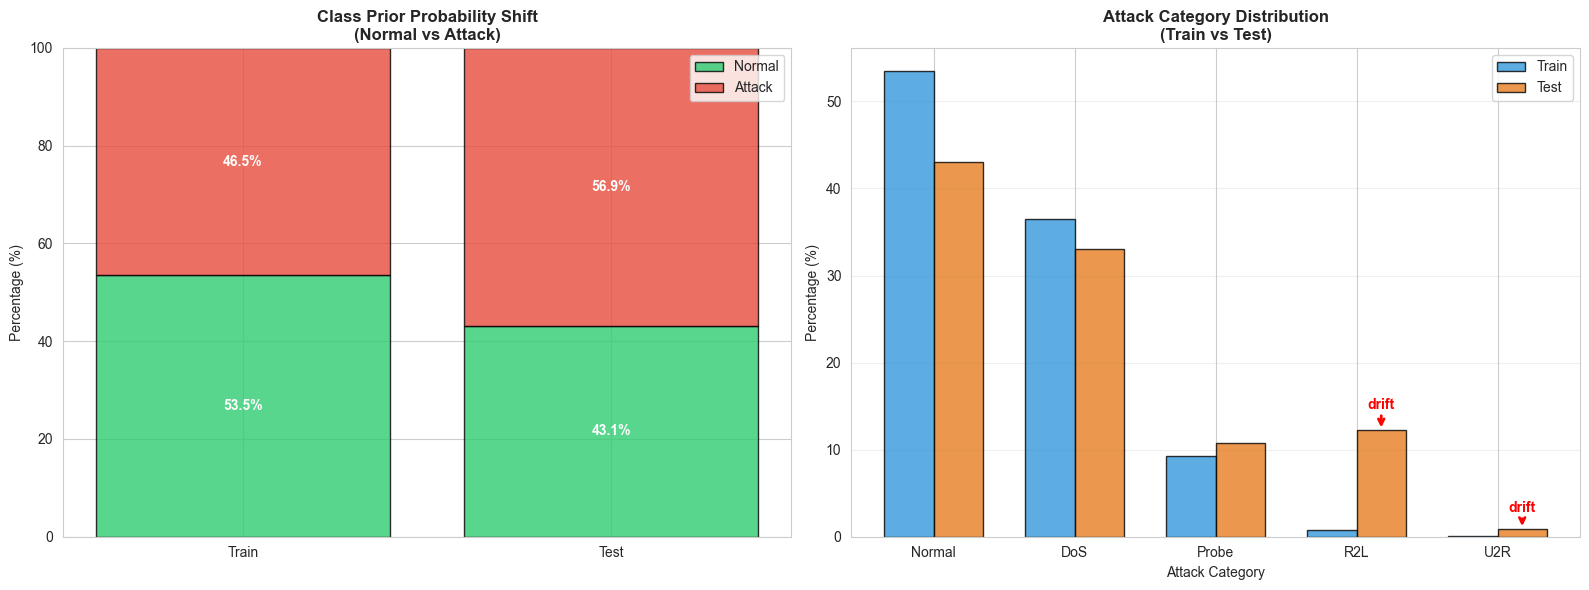

In [24]:
# ============================================
# VISUALIZATION: 2 Charts (Normal vs Attack + Category Distribution)
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Chart 1: Normal vs Attack (Stacked Bar)
datasets = ['Train', 'Test']
normal_vals = [train_normal_pct, test_normal_pct]
attack_vals = [train_attack_pct, test_attack_pct]

axes[0].bar(datasets, normal_vals, label='Normal', color='#2ecc71', alpha=0.8, edgecolor='black')
axes[0].bar(datasets, attack_vals, bottom=normal_vals, label='Attack', color='#e74c3c', alpha=0.8, edgecolor='black')
axes[0].set_ylabel('Percentage (%)')
axes[0].set_title('Class Prior Probability Shift\n(Normal vs Attack)', fontweight='bold')
axes[0].legend()
axes[0].set_ylim(0, 100)
for i, (n, a) in enumerate(zip(normal_vals, attack_vals)):
    axes[0].text(i, n/2, f'{n:.1f}%', ha='center', va='center', fontweight='bold', color='white')
    axes[0].text(i, n + a/2, f'{a:.1f}%', ha='center', va='center', fontweight='bold', color='white')

# Chart 2: Category Distribution (Grouped Bar)
x = np.arange(len(categories_list))
width = 0.35

train_values = [train_cat_pct.get(cat, 0) for cat in categories_list]
test_values = [test_cat_pct.get(cat, 0) for cat in categories_list]

bars1 = axes[1].bar(x - width/2, train_values, width, label='Train', color='#3498db', alpha=0.8, edgecolor='black')
bars2 = axes[1].bar(x + width/2, test_values, width, label='Test', color='#e67e22', alpha=0.8, edgecolor='black')

axes[1].set_xlabel('Attack Category')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_title('Attack Category Distribution\n(Train vs Test)', fontweight='bold')
axes[1].set_xticks(x)
axes[1].set_xticklabels(categories_list)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

# Highlight R2L với annotation
r2l_idx = categories_list.index('R2L')
axes[1].annotate('', xy=(r2l_idx + width/2, test_cat_pct.get('R2L', 0)), 
                xytext=(r2l_idx + width/2, test_cat_pct.get('R2L', 0) + 2),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
axes[1].text(r2l_idx + width/2, test_cat_pct.get('R2L', 0) + 2.5, 
            'drift', ha='center', fontsize=10, fontweight='bold', color='red')

# Highlight U2R với annotation
u2r_idx = categories_list.index('U2R')
axes[1].annotate('', xy=(u2r_idx + width/2, test_cat_pct.get('U2R', 0)), 
                xytext=(u2r_idx + width/2, test_cat_pct.get('U2R', 0) + 1.5),
                arrowprops=dict(arrowstyle='->', color='red', lw=2))
axes[1].text(u2r_idx + width/2, test_cat_pct.get('U2R', 0) + 2, 
            'drift', ha='center', fontsize=10, fontweight='bold', color='red')

plt.tight_layout()
plt.show()

In [ ]:
# ============================================
# R2L & U2R SUDDEN DRIFT VISUALIZATION (Combined)
# INPUT: train_r2l, test_r2l, train_u2r, test_u2r (absolute counts)
# PROCESS: Vẽ 2 pie charts side-by-side so sánh R2L và U2R Train vs Test
# OUTPUT: 1x2 subplots với pie charts
# MỤC ĐÍCH: Visual comparison R2L (2.8x) và U2R (3.8x) drift patterns
# ============================================

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# ========== Chart 1: R2L Sudden Drift ==========
r2l_comparison = [train_r2l, test_r2l]
labels_r2l = ['Train R2L', 'Test R2L']
colors_pie_r2l = ['#3498db', '#e67e22']
explode_r2l = (0, 0.1)

wedges_r2l, texts_r2l, autotexts_r2l = axes[0].pie(
    r2l_comparison,
    labels=labels_r2l,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode_r2l,
    colors=colors_pie_r2l,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

# Style R2L labels
for text in texts_r2l:
    text.set_fontsize(11)
    text.set_fontweight('bold')
for autotext in autotexts_r2l:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

# R2L Title
axes[0].set_title(f'R2L Sudden Drift\n(Test = {r2l_multiplier:.1f}× Train)', 
                  fontweight='bold', color='#e74c3c', fontsize=13)

# R2L Legend
legend_labels_r2l = [
    f"Train: {train_r2l:,} samples ({train_cat_pct.get('R2L', 0):.2f}%)",
    f"Test: {test_r2l:,} samples ({test_cat_pct.get('R2L', 0):.2f}%)"
]
axes[0].legend(legend_labels_r2l, loc='upper left', fontsize=10)

# ========== Chart 2: U2R Extreme Drift ==========
u2r_comparison = [train_u2r, test_u2r]
labels_u2r = ['Train U2R', 'Test U2R']
colors_pie_u2r = ['#9b59b6', '#f39c12']
explode_u2r = (0, 0.1)

wedges_u2r, texts_u2r, autotexts_u2r = axes[1].pie(
    u2r_comparison,
    labels=labels_u2r,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode_u2r,
    colors=colors_pie_u2r,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

# Style U2R labels
for text in texts_u2r:
    text.set_fontsize(11)
    text.set_fontweight('bold')
for autotext in autotexts_u2r:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

# U2R Title
axes[1].set_title(f'U2R Extreme Drift\n(Test = {u2r_multiplier:.1f}× Train)', 
                  fontweight='bold', color='#e74c3c', fontsize=13)

# U2R Legend
legend_labels_u2r = [
    f"Train: {train_u2r:,} samples ({train_cat_pct.get('U2R', 0):.2f}%)",
    f"Test: {test_u2r:,} samples ({test_cat_pct.get('U2R', 0):.2f}%)"
]
axes[1].legend(legend_labels_u2r, loc='upper left', fontsize=10)

plt.suptitle('Class Imbalance: R2L & U2R Sudden Drift Analysis', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("🎯 SUDDEN DRIFT SUMMARY")
print("="*80)
print(f"R2L: Train {train_r2l:,} ({train_cat_pct.get('R2L', 0):.2f}%) → Test {test_r2l:,} ({test_cat_pct.get('R2L', 0):.2f}%) | {r2l_multiplier:.1f}x")
print(f"U2R: Train {train_u2r:,} ({train_cat_pct.get('U2R', 0):.2f}%) → Test {test_u2r:,} ({test_cat_pct.get('U2R', 0):.2f}%) | {u2r_multiplier:.1f}x")
print("="*80)

<Figure size 1200x600 with 0 Axes>

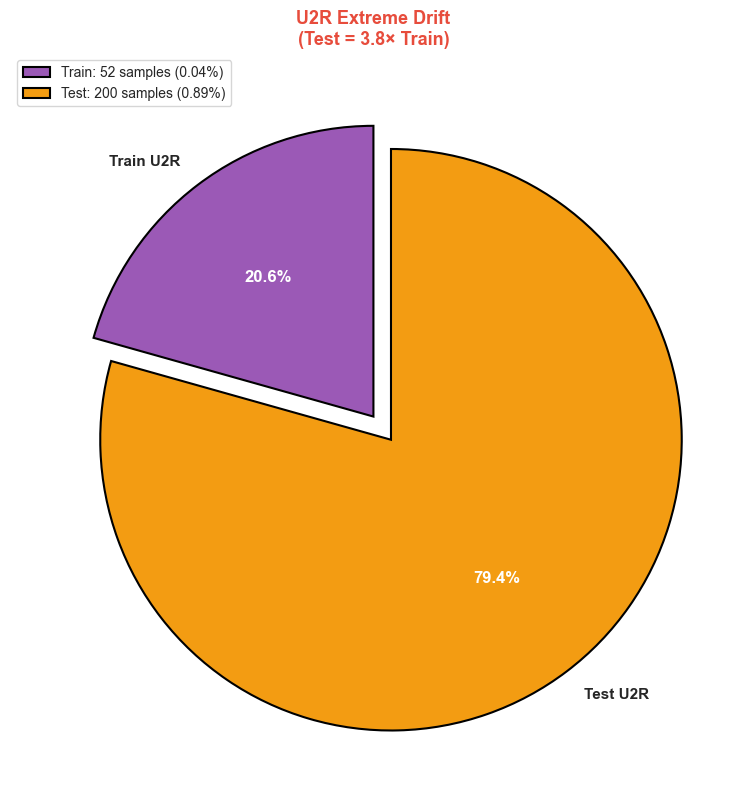


🎯 U2R EXTREME DRIFT:
Train: 52 samples (0.04%)
Test:  200 samples (0.89%)


In [20]:
# ============================================
# U2R SUDDEN DRIFT VISUALIZATION
# INPUT: train_u2r, test_u2r (absolute counts)
# PROCESS: Vẽ pie chart so sánh tỷ lệ U2R Train vs Test
# OUTPUT: Pie với 2 slices + percentages + legend với số liệu chi tiết
# MỤC ĐÍCH: Visual highlight Test U2R gấp 3.8x Train (Extreme Drift)
# ============================================

train_u2r = train_cat_counts.get('U2R', 0)
test_u2r = test_cat_counts.get('U2R', 0)
u2r_multiplier = test_u2r / train_u2r if train_u2r > 0 else float('inf')

u2r_comparison = [train_u2r, test_u2r]
labels_u2r = ['Train U2R', 'Test U2R']
colors_pie_u2r = ['#9b59b6', '#f39c12']
explode_u2r = (0, 0.1)

fig, ax = plt.subplots(figsize=(10, 8))

wedges_u2r, texts_u2r, autotexts_u2r = ax.pie(
    u2r_comparison,
    labels=labels_u2r,
    autopct='%1.1f%%',
    startangle=90,
    explode=explode_u2r,
    colors=colors_pie_u2r,
    wedgeprops={'edgecolor': 'black', 'linewidth': 1.5}
)

# Style labels và percentages
for text in texts_u2r:
    text.set_fontsize(11)
    text.set_fontweight('bold')
for autotext in autotexts_u2r:
    autotext.set_color('white')
    autotext.set_fontsize(12)
    autotext.set_fontweight('bold')

# Title
ax.set_title(f'U2R Extreme Drift\n(Test = {u2r_multiplier:.1f}× Train)', 
             fontweight='bold', color='#e74c3c', fontsize=13)

# Legend với detailed numbers
legend_labels_u2r = [
    f"Train: {train_u2r:,} samples ({train_cat_pct.get('U2R', 0):.2f}%)",
    f"Test: {test_u2r:,} samples ({test_cat_pct.get('U2R', 0):.2f}%)"
]
ax.legend(legend_labels_u2r, loc='upper left', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n🎯 U2R EXTREME DRIFT:")
print(f"Train: {train_u2r:,} samples ({train_cat_pct.get('U2R', 0):.2f}%)")
print(f"Test:  {test_u2r:,} samples ({test_cat_pct.get('U2R', 0):.2f}%)")

In [12]:
# ============================================
# CHECK DoS và Probe attacks chi tiết
# ============================================

print("\n" + "="*80)
print("🔍 DETAILED ATTACK BREAKDOWN (DoS và Probe)")
print("="*80)

# DoS breakdown
print("\nDoS Attacks in TEST:")
dos_test = df_test[df_test['category'] == 'DoS']['attack_type'].value_counts()
for attack, count in dos_test.items():
	print(f"  {attack:20} {count:4,} samples")
print(f"  {'TOTAL':20} {dos_test.sum():4,} samples")

print("\nDoS Attacks in TRAIN:")
dos_train = df_train[df_train['category'] == 'DoS']['attack_type'].value_counts()
for attack, count in dos_train.items():
	print(f"  {attack:20} {count:4,} samples")
print(f"  {'TOTAL':20} {dos_train.sum():4,} samples")

# Probe breakdown
print("\n\nProbe Attacks in TEST:")
probe_test = df_test[df_test['category'] == 'Probe']['attack_type'].value_counts()
for attack, count in probe_test.items():
	print(f"  {attack:20} {count:4,} samples")
print(f"  {'TOTAL':20} {probe_test.sum():4,} samples")

print("\nProbe Attacks in TRAIN:")
probe_train = df_train[df_train['category'] == 'Probe']['attack_type'].value_counts()
for attack, count in probe_train.items():
	print(f"  {attack:20} {count:4,} samples")
print(f"  {'TOTAL':20} {probe_train.sum():4,} samples")

print("\n" + "="*80)


🔍 DETAILED ATTACK BREAKDOWN (DoS và Probe)

DoS Attacks in TEST:
  neptune              4,657 samples
  apache2               737 samples
  processtable          685 samples
  smurf                 665 samples
  back                  359 samples
  mailbomb              293 samples
  pod                    41 samples
  teardrop               12 samples
  land                    7 samples
  udpstorm                2 samples
  TOTAL                7,458 samples

DoS Attacks in TRAIN:
  neptune              41,214 samples
  smurf                2,646 samples
  back                  956 samples
  teardrop              892 samples
  pod                   201 samples
  land                   18 samples
  TOTAL                45,927 samples


Probe Attacks in TEST:
  mscan                 996 samples
  satan                 735 samples
  saint                 319 samples
  portsweep             157 samples
  ipsweep               141 samples
  nmap                   73 samples
  TOTAL        

In [13]:
# ============================================
# CHECK U2R và R2L attacks chi tiết
# ============================================

print("\n" + "="*80)
print("🔍 DETAILED ATTACK BREAKDOWN (U2R và R2L)")
print("="*80)

# U2R breakdown
print("\nU2R Attacks in TEST:")
u2r_test = df_test[df_test['category'] == 'U2R']['attack_type'].value_counts()
for attack, count in u2r_test.items():
    print(f"  {attack:20} {count:4,} samples")
print(f"  {'TOTAL':20} {u2r_test.sum():4,} samples")

print("\nU2R Attacks in TRAIN:")
u2r_train = df_train[df_train['category'] == 'U2R']['attack_type'].value_counts()
for attack, count in u2r_train.items():
    print(f"  {attack:20} {count:4,} samples")
print(f"  {'TOTAL':20} {u2r_train.sum():4,} samples")

# R2L breakdown
print("\n\nR2L Attacks in TEST:")
r2l_test = df_test[df_test['category'] == 'R2L']['attack_type'].value_counts()
for attack, count in r2l_test.items():
    print(f"  {attack:20} {count:4,} samples")
print(f"  {'TOTAL':20} {r2l_test.sum():4,} samples")

print("\nR2L Attacks in TRAIN:")
r2l_train = df_train[df_train['category'] == 'R2L']['attack_type'].value_counts()
for attack, count in r2l_train.items():
    print(f"  {attack:20} {count:4,} samples")
print(f"  {'TOTAL':20} {r2l_train.sum():4,} samples")

print("\n" + "="*80)


🔍 DETAILED ATTACK BREAKDOWN (U2R và R2L)

U2R Attacks in TEST:
  httptunnel            133 samples
  buffer_overflow        20 samples
  ps                     15 samples
  xterm                  13 samples
  rootkit                13 samples
  loadmodule              2 samples
  perl                    2 samples
  sqlattack               2 samples
  TOTAL                 200 samples

U2R Attacks in TRAIN:
  buffer_overflow        30 samples
  rootkit                10 samples
  loadmodule              9 samples
  perl                    3 samples
  TOTAL                  52 samples


R2L Attacks in TEST:
  guess_passwd         1,231 samples
  warezmaster           944 samples
  snmpguess             331 samples
  snmpgetattack         178 samples
  multihop               18 samples
  named                  17 samples
  sendmail               14 samples
  xlock                   9 samples
  xsnoop                  4 samples
  ftp_write               3 samples
  worm                   

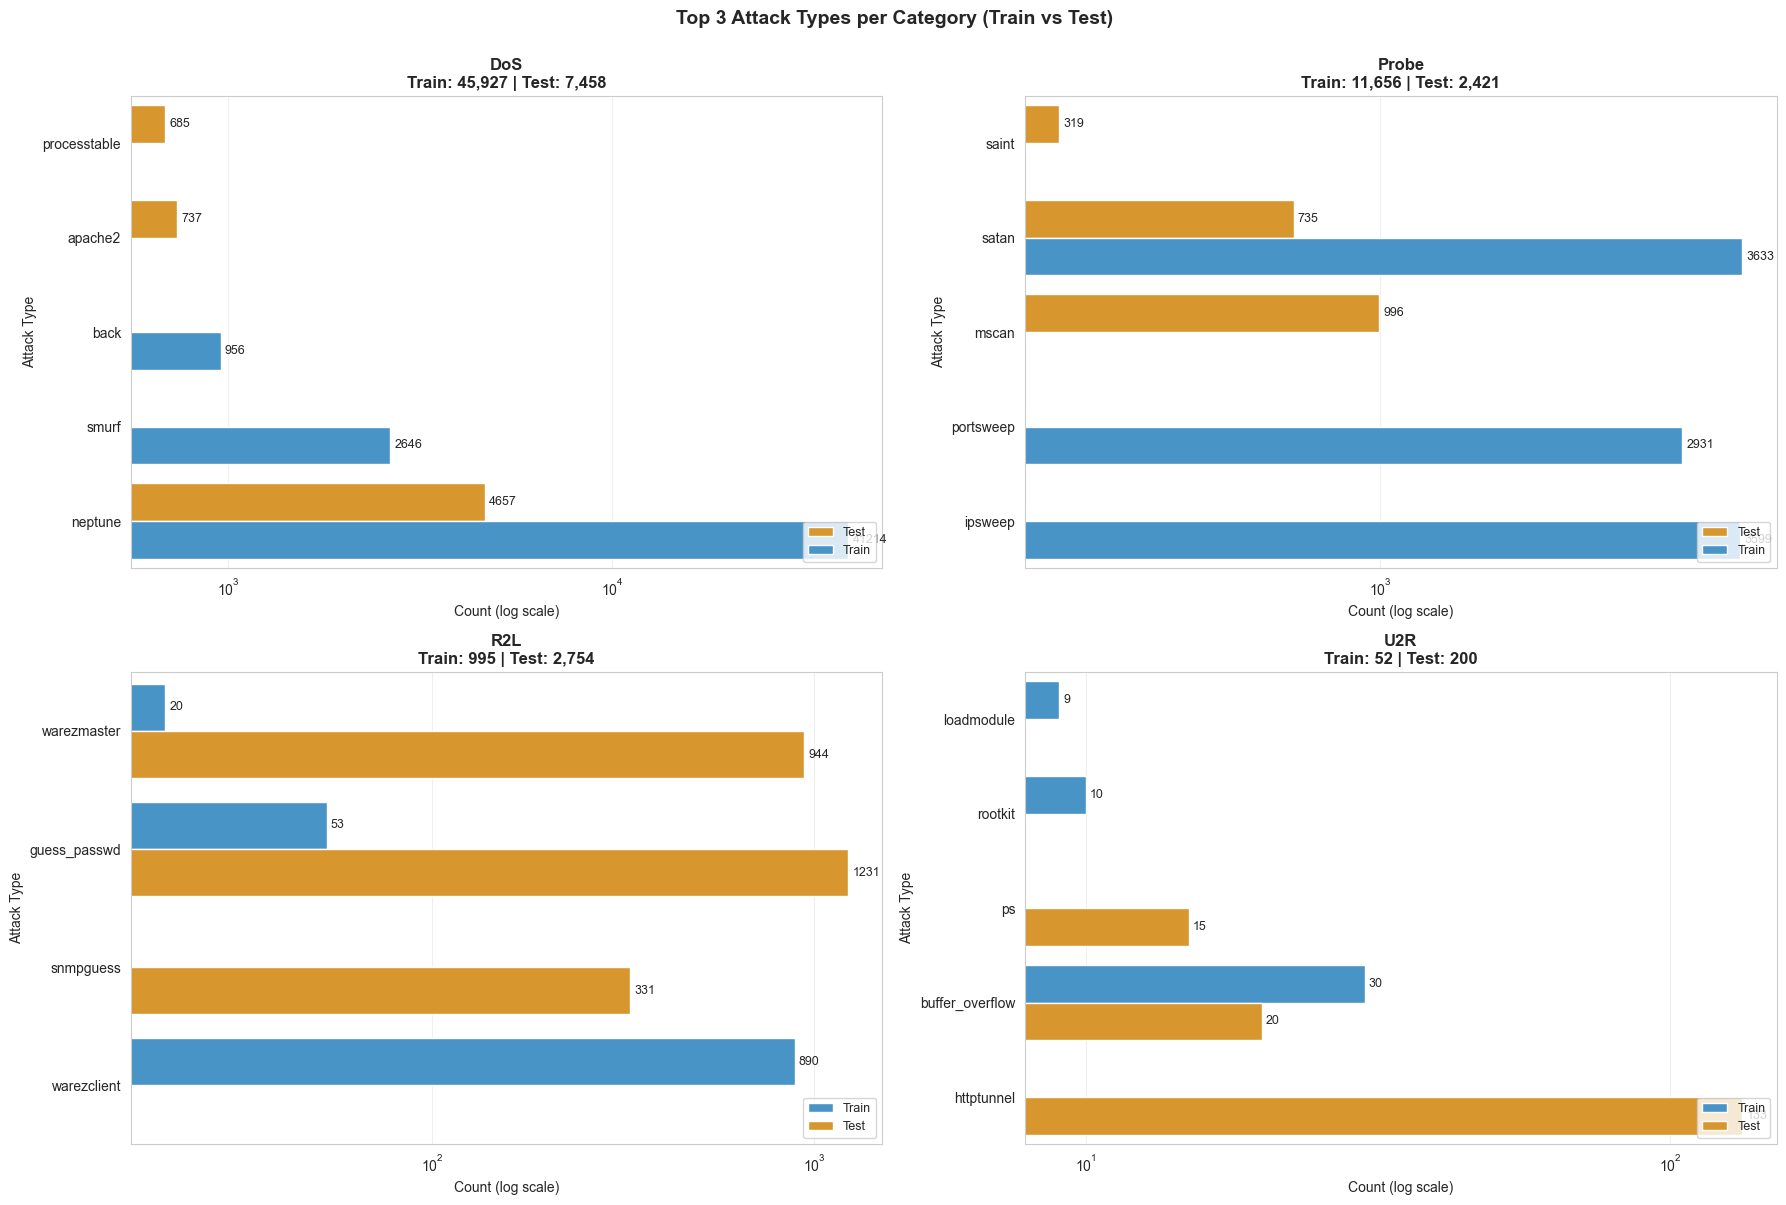

✅ Top 3 attacks visualized for 4 categories


In [14]:
# ============================================
# TOP 3 ATTACKS VISUALIZATION PER CATEGORY
# INPUT: df_train, df_test với category column
# PROCESS: 
#   1. Count FULL tất cả attacks trong Train (không limit top 6)
#   2. Count FULL tất cả attacks trong Test (không limit top 6)
#   3. Combine 2 DataFrames
#   4. SAU ĐÓ MỚI lấy top 3 cho mỗi (category, Dataset)
#   5. Vẽ 4 subplots (DoS, Probe, R2L, U2R)
# OUTPUT: 2x2 grid charts với horizontal bars
# MỤC ĐÍCH: So sánh ĐÚNG top attacks giữa Train vs Test (không bỏ sót attacks nằm ngoài top 6)
# ============================================

# Step 1: Count FULL attacks từ Train (4 categories: DoS, Probe, R2L, U2R)
categories_to_analyze = ['DoS', 'Probe', 'R2L', 'U2R']
full_train_counts = (
    df_train[df_train['category'].isin(categories_to_analyze)]
    .groupby(['category', 'attack_type'])
    .size()
    .reset_index(name='count')
)
full_train_counts['Dataset'] = 'Train'

# Step 2: Count FULL attacks từ Test
full_test_counts = (
    df_test[df_test['category'].isin(categories_to_analyze)]
    .groupby(['category', 'attack_type'])
    .size()
    .reset_index(name='count')
)
full_test_counts['Dataset'] = 'Test'

# Step 3: Combine FULL data
full_combined = pd.concat([full_train_counts, full_test_counts], ignore_index=True)

# Step 4: SAU ĐÓ MỚI lấy top 3 cho mỗi (category, Dataset)
top3_list = []
for (cat, dataset), group in full_combined.groupby(['category', 'Dataset']):
    top3 = group.nlargest(3, 'count')
    top3_list.append(top3)

top3_combined = pd.concat(top3_list, ignore_index=True)

# Step 4: Visualize
categories = ['DoS', 'Probe', 'R2L', 'U2R']
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
axes = axes.flatten()

for ax, cat in zip(axes, categories):
    # Filter data cho category này
    data_cat = top3_combined[top3_combined['category'] == cat].copy()
    
    if len(data_cat) == 0:
        ax.text(0.5, 0.5, f'No data for {cat}', ha='center', va='center')
        ax.set_title(cat, fontweight='bold')
        continue
    
    # Sort để chart dễ đọc (smallest on top)
    data_cat = data_cat.sort_values('count', ascending=True)
    
    # Plot với màu thống nhất: Train = xanh (#3498db), Test = vàng (#f39c12)
    sns.barplot(
        data=data_cat,
        x='count',
        y='attack_type',
        hue='Dataset',
        ax=ax,
        palette={'Train': '#3498db', 'Test': '#f39c12'},
        dodge=True  # Bars cạnh nhau thay vì overlap
    )
    
    # Add value labels
    for container in ax.containers:
        ax.bar_label(container, fmt='%d', padding=3, fontsize=9)
    
    # Tính FULL count của category (tất cả attacks, không chỉ top 3)
    train_full_count = len(df_train[df_train['category'] == cat])
    test_full_count = len(df_test[df_test['category'] == cat])
    
    # Styling
    ax.set_title(
        f'{cat}\nTrain: {train_full_count:,} | Test: {test_full_count:,}', 
        fontweight='bold', 
        fontsize=12
    )
    ax.set_xlabel('Count (log scale)', fontsize=10)
    ax.set_ylabel('Attack Type', fontsize=10)
    ax.set_xscale('log')
    ax.grid(axis='x', alpha=0.3)
    ax.legend(loc='lower right', fontsize=9)

plt.suptitle('Top 3 Attack Types per Category (Train vs Test)', 
             fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

print(f"✅ Top 3 attacks visualized for {len(categories)} categories")


## 6. Difficulty distribution


📊 DIFFICULTY ANALYSIS (for Incremental Scenario Design)

Normal  
  Train: mean=20.32, std= 1.48, min= 1, max=21
  Test:  mean=19.96, std= 2.86, min= 0, max=21

DoS     
  Train: mean=19.31, std= 1.78, min= 3, max=21
  Test:  mean=18.63, std= 2.94, min= 1, max=21

Probe   
  Train: mean=16.46, std= 2.82, min= 0, max=21
  Test:  mean=15.85, std= 3.31, min= 0, max=21

R2L     
  Train: mean= 9.88, std= 4.03, min= 0, max=19
  Test:  mean=11.98, std= 5.00, min= 0, max=19

U2R     
  Train: mean= 4.40, std= 3.95, min= 0, max=14
  Test:  mean=10.27, std= 6.54, min= 0, max=20


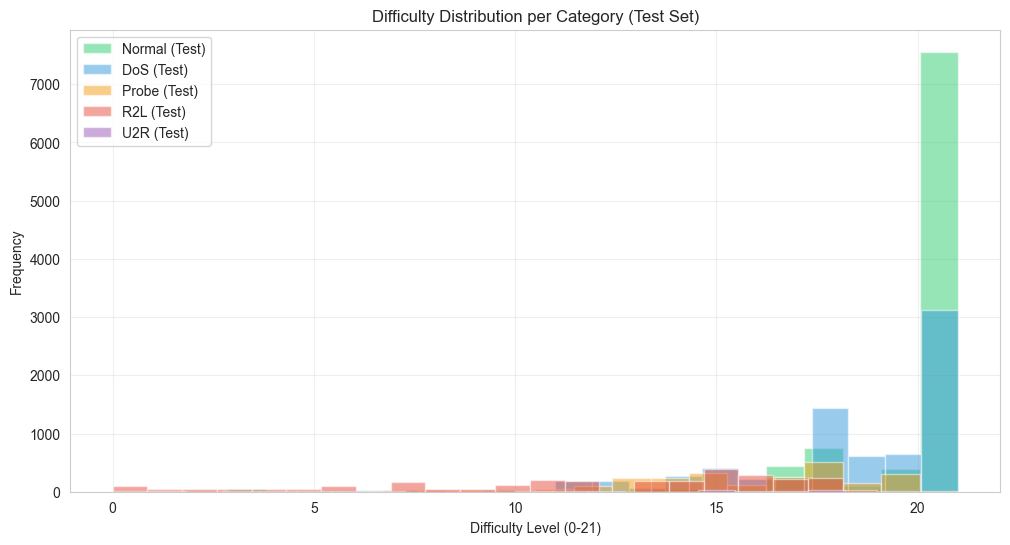

In [15]:
print("\n" + "="*80)
print("📊 DIFFICULTY ANALYSIS (for Incremental Scenario Design)")
print("="*80)

for cat in ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']:
    df_train_cat = df_train[df_train['category'] == cat]
    df_test_cat = df_test[df_test['category'] == cat]
    
    train_diff = df_train_cat['difficulty'].describe()
    test_diff = df_test_cat['difficulty'].describe()
    
    print(f"\n{cat:8}")
    print(f"  Train: mean={train_diff['mean']:5.2f}, std={train_diff['std']:5.2f}, "
          f"min={train_diff['min']:2.0f}, max={train_diff['max']:2.0f}")
    print(f"  Test:  mean={test_diff['mean']:5.2f}, std={test_diff['std']:5.2f}, "
          f"min={test_diff['min']:2.0f}, max={test_diff['max']:2.0f}")

# Visualize difficulty distribution
fig, ax = plt.subplots(figsize=(12, 6))
for cat, color in zip(['Normal', 'DoS', 'Probe', 'R2L', 'U2R'], 
                       ['#2ecc71', '#3498db', '#f39c12', '#e74c3c', '#9b59b6']):
    test_difficulty = df_test[df_test['category'] == cat]['difficulty']
    ax.hist(test_difficulty, bins=22, alpha=0.5, label=f'{cat} (Test)', color=color)

ax.set_xlabel('Difficulty Level (0-21)')
ax.set_ylabel('Frequency')
ax.set_title('Difficulty Distribution per Category (Test Set)')
ax.legend()
ax.grid(alpha=0.3)
plt.show()

## 7. Feature drift analysis

In [16]:
print("\n" + "="*80)
print("🔍 FEATURE DRIFT ANALYSIS (Covariate Shift Evidence)")
print("="*80)

# Key features để phân tích
numeric_features = ['duration', 'src_bytes', 'dst_bytes', 
                    'count', 'srv_count', 'serror_rate', 
                    'same_srv_rate', 'dst_host_count']

feature_drift = []
for feat in numeric_features:
    train_mean = df_train[feat].mean()
    train_std = df_train[feat].std()
    test_mean = df_test[feat].mean()
    test_std = df_test[feat].std()
    
    drift_pct = ((test_mean - train_mean) / train_mean * 100) if train_mean != 0 else 0
    
    feature_drift.append({
        'Feature': feat,
        'Train Mean': f"{train_mean:,.2f}",
        'Test Mean': f"{test_mean:,.2f}",
        'Drift %': f"{drift_pct:+.1f}%",
        'Train Std': f"{train_std:,.2f}",
        'Test Std': f"{test_std:,.2f}"
    })

df_feature_drift = pd.DataFrame(feature_drift)
print(df_feature_drift.to_string(index=False))

print("\n💡 INTERPRETATION:")
print("  - Positive drift: Test có feature values cao hơn Train")
print("  - Negative drift: Test có feature values thấp hơn Train")
print("  - Large drift (>50%): Strong evidence of covariate shift")


🔍 FEATURE DRIFT ANALYSIS (Covariate Shift Evidence)
       Feature Train Mean Test Mean Drift %    Train Std   Test Std
      duration     287.14    218.86  -23.8%     2,604.52   1,407.18
     src_bytes  45,566.74 10,395.45  -77.2% 5,870,331.18 472,786.43
     dst_bytes  19,779.11  2,056.02  -89.6% 4,021,269.15  21,219.30
         count      84.11     79.03   -6.0%       114.51     128.54
     srv_count      27.74     31.12  +12.2%        72.64      89.06
   serror_rate       0.28      0.10  -63.8%         0.45       0.30
 same_srv_rate       0.66      0.74  +12.0%         0.44       0.41
dst_host_count     182.15    193.87   +6.4%        99.21      94.04

💡 INTERPRETATION:
  - Positive drift: Test có feature values cao hơn Train
  - Negative drift: Test có feature values thấp hơn Train
  - Large drift (>50%): Strong evidence of covariate shift


## 8. Kịch bản Catastrophic Forgetting 

In [17]:
print("\n" + "="*80)
print("🎯 CATASTROPHIC FORGETTING SCENARIO DESIGN")
print("="*80)

print("\n📌 PHASE 0: Baseline Model (Pre-drift)")
print("-" * 80)
phase0_train = df_train[df_train['category'].isin(['Normal', 'DoS', 'Probe'])]
phase0_test = df_test[df_test['category'].isin(['Normal', 'DoS', 'Probe'])]
print(f"Training samples: {len(phase0_train):,}")
print(f"Testing samples:  {len(phase0_test):,}")
print(f"Classes: 3 (Normal, DoS, Probe)")
print(f"Expected baseline accuracy: ~95%+")

print("\n📌 PHASE 1: R2L Introduction (Sudden Drift)")
print("-" * 80)
phase1_r2l_train = df_train[df_train['category'] == 'R2L']
phase1_r2l_test = df_test[df_test['category'] == 'R2L']
print(f"New R2L training samples: {len(phase1_r2l_train):,} (0.79% of original train)")
print(f"New R2L testing samples:  {len(phase1_r2l_test):,} (12.2% of test)")
print(f"Multiplier: {len(phase1_r2l_test) / len(phase1_r2l_train):.1f}x")
print(f"Zero-day R2L attacks: {len([a for a in new_attacks if df_test[df_test['attack_type'] == a].iloc[0]['category'] == 'R2L' if len(df_test[df_test['attack_type'] == a]) > 0])}")
print(f"Expected issues:")
print(f"  ✗ Catastrophic forgetting on Normal/DoS/Probe")
print(f"  ✗ Class imbalance (R2L very rare in train)")
print(f"  ✗ Zero-day attacks not seen during training")

print("\n📌 PHASE 2: U2R Introduction (Extreme Drift)")
print("-" * 80)
phase2_u2r_train = df_train[df_train['category'] == 'U2R']
phase2_u2r_test = df_test[df_test['category'] == 'U2R']
print(f"New U2R training samples: {len(phase2_u2r_train):,} (0.04% of original train)")
print(f"New U2R testing samples:  {len(phase2_u2r_test):,} (0.89% of test)")
print(f"Multiplier: {len(phase2_u2r_test) / len(phase2_u2r_train):.1f}x")
print(f"Expected issues:")
print(f"  ✗ Extreme catastrophic forgetting (52 samples only!)")
print(f"  ✗ Model bias towards majority classes")
print(f"  ✗ Nearly impossible to learn U2R without proper techniques")

print("\n" + "="*80)
print("✅ SCENARIO READY for:")
print("  1. Incremental learning experiments")
print("  2. Catastrophic forgetting measurement")
print("  3. Adaptive Random Forest comparison")
print("="*80)


🎯 CATASTROPHIC FORGETTING SCENARIO DESIGN

📌 PHASE 0: Baseline Model (Pre-drift)
--------------------------------------------------------------------------------
Training samples: 124,926
Testing samples:  19,590
Classes: 3 (Normal, DoS, Probe)
Expected baseline accuracy: ~95%+

📌 PHASE 1: R2L Introduction (Sudden Drift)
--------------------------------------------------------------------------------
New R2L training samples: 995 (0.79% of original train)
New R2L testing samples:  2,754 (12.2% of test)
Multiplier: 2.8x
Zero-day R2L attacks: 7
Expected issues:
  ✗ Catastrophic forgetting on Normal/DoS/Probe
  ✗ Class imbalance (R2L very rare in train)
  ✗ Zero-day attacks not seen during training

📌 PHASE 2: U2R Introduction (Extreme Drift)
--------------------------------------------------------------------------------
New U2R training samples: 52 (0.04% of original train)
New U2R testing samples:  200 (0.89% of test)
Multiplier: 3.8x
Expected issues:
  ✗ Extreme catastrophic forgetti